In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.ndimage import gaussian_filter1d
import math

In [22]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

base_path_for_images = 'D:\PycharmProjects\spinedetector\experiments\for_prediplom_report'

Проверим поведение меры градиента на синтетических данных.
Нам нужно, чтобы наш фильтр не реагировал на шумы

In [3]:
def get_gradient(data):
    gradient = np.diff(data, 1, axis=0)
    norm = np.zeros_like(data)

    norm[:-1] += gradient
    norm[1:] += gradient

    norm = np.abs(norm)

    assert not np.argwhere(np.isnan(norm))
    #norm = np.nan_to_num(norm)
    return norm

def box_filtering(data, degree=2, size=(3,)):
    inverse_grad = get_gradient(data)
    csum = np.cumsum(get_gradient(data) ** degree, axis=0)

    csum = (csum[2 * size[0]:] - csum[:-2 * size[0]])/(2*size[0] + 1)
    csum = np.power(csum, 1/degree)
    result = np.zeros_like(data)
    result[size[0]: -size[0]] = csum 
    
    return result


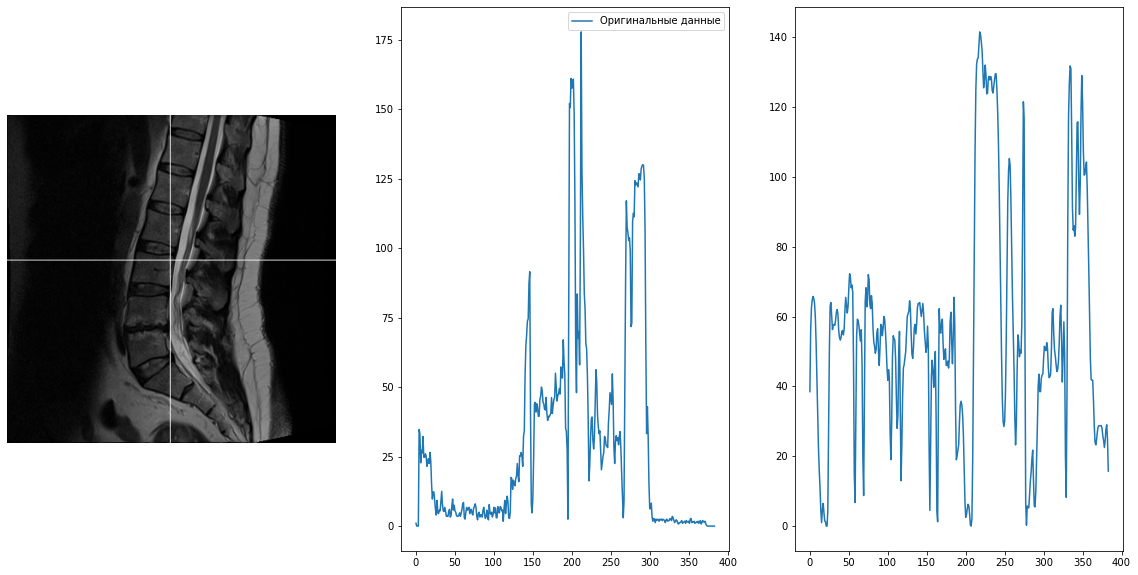

In [37]:
from copy import  copy
from spine_detector.utils import load_mri

dcms = load_mri('D:\PycharmProjects\spinedetector\\test-data\\0001\T2_TSE_SAG_384_0002')

tst_image = dcms[7].pixel_array

h_slice_number = 170
v_slice_number = 190
h_slice = tst_image[slice_number] / 4
v_slice = tst_image[:, v_slice_number] / 4

tst_image[h_slice_number] = 1048
tst_image[:, v_slice_number] = 1048
#tst_image[:, 192] = 1024
#tst_image[:, 147] = 1024

fig, ax = plt.subplots(ncols=3, figsize=(20,10))

ax[0].imshow(tst_image, cmap='gray')
ax[0].axis('off')


vertbrae_area = patches.Rectangle((147,0), 45, 165, linewidth=1, edgecolor='g', facecolor='none')
ax[1].plot(h_slice)
ax[1].legend(['Оригинальные данные', 'Область позвоночника', 'Область спинного мозга'])

ax[2].plot(v_slice)


(-0.5, 383.5, 383.5, -0.5)

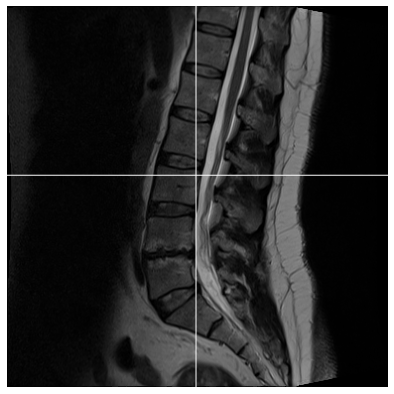

In [43]:
# Сохраняем изображения для практики
fig, ax = plt.subplots(figsize=(7,7))

ax.imshow(tst_image, cmap='gray')
ax.axis('off')


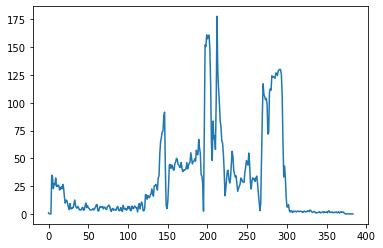

In [41]:
plt.plot(h_slice)

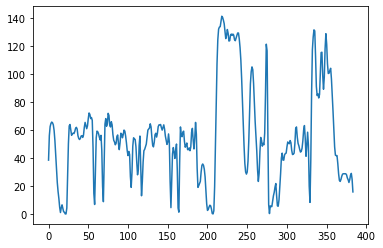

In [42]:
plt.plot(v_slice)

Поиграемся с синтетическими данными:
* экспонента
* сигмоид
* линейная функция с плато

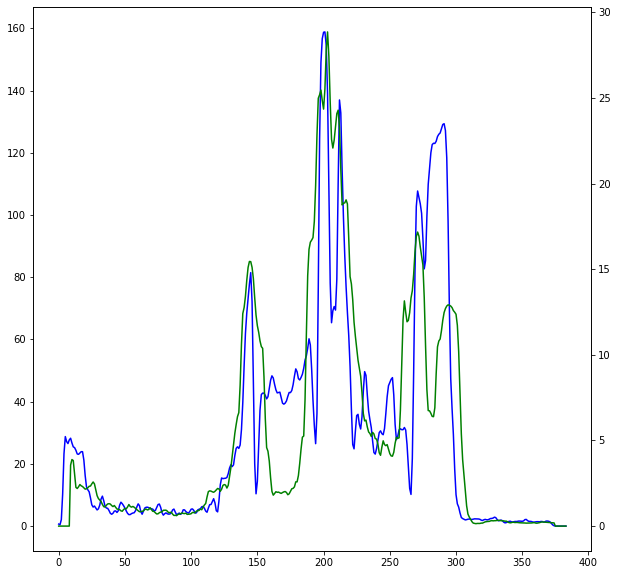

In [5]:
#plt.plot(central_slice[120:250])

after_gauss = gaussian_filter1d(central_slice, 1)

size=9
degree=0.9

box_filtered_data = box_filtering(after_gauss, degree, size=(size,))

fig, ax = plt.subplots(figsize=(10,10))

ax2 = ax.twinx()
ax.plot(after_gauss, '-b')

ax2.plot(box_filtered_data, '-g')

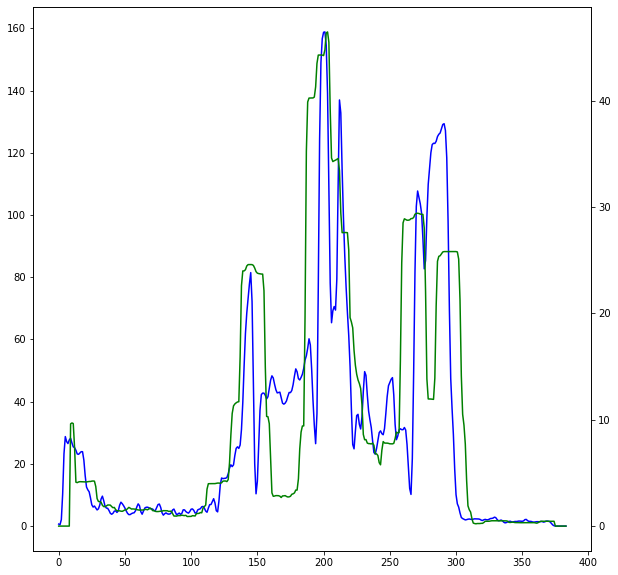

In [6]:
after_gauss = gaussian_filter1d(central_slice, 1)

size=9
degree=3

box_filtered_data = box_filtering(after_gauss, degree, size=(size,))

fig, ax = plt.subplots(figsize=(10,10))

ax2 = ax.twinx()
ax.plot(after_gauss, '-b')

ax2.plot(box_filtered_data, '-g')

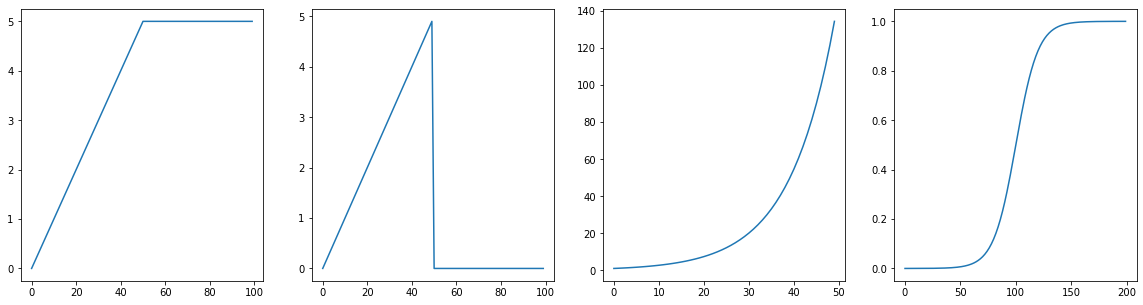

In [7]:
linear_data_with_plato_1 = np.hstack([np.arange(0, 5, .1), np.ones(50)*5])
linear_data_with_plato_2 = np.hstack([np.arange(0, 5, .1), np.zeros(50)])
exponent_data = np.exp(np.arange(0, 5, .1))
sigmoid_data = 1/(1 + np.exp(np.arange(10, -10, -.1)))


fig, ax = plt.subplots(ncols=4, figsize=(20,5))
ax[0].plot(linear_data_with_plato_1)
ax[1].plot(linear_data_with_plato_2)
ax[2].plot(exponent_data)
ax[3].plot(sigmoid_data)

In [8]:
def separability_stats(box_filtered_data, size=1, edge_position=50):
    first_region = box_filtered_data[size:edge_position]
    min_first = first_region.min()
    max_first = first_region.max()

    second_region = box_filtered_data[edge_position:-size]
    min_second = second_region.min()
    max_second = second_region.max()

    return min_first, len(np.argwhere(second_region <= min_first)) / 50

def separability_stats_2(box_filtered_data, size=1, edge_position=50):
    first_region = box_filtered_data[size:edge_position]
    min_first = first_region.min()
    max_first = first_region.max()

    second_region = box_filtered_data[edge_position:-size]
    min_second = second_region.min()
    max_second = second_region.max()

    return min_second, len(np.argwhere(first_region <= min_second)) / 50

(0.08933152628776285, 0.98)


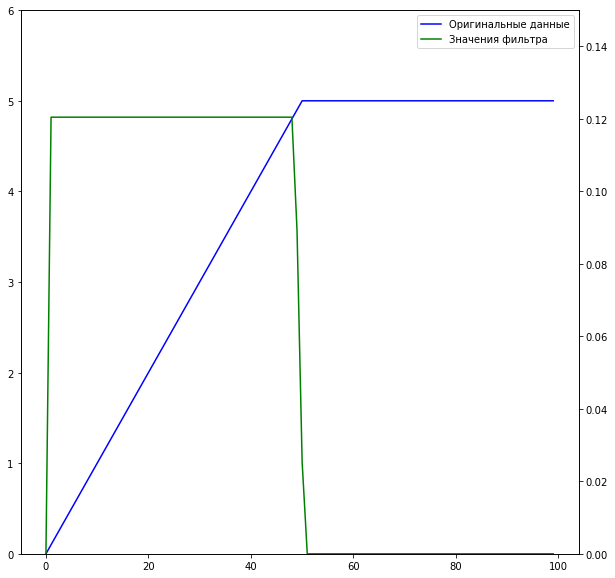

In [54]:
# эксперементируем с плато
box_filtered_data = box_filtering(linear_data_with_plato_1, .8, size=(1,))

fig, ax = plt.subplots(figsize=(10,10))

ax2 = ax.twinx()
lns1 = ax.plot(linear_data_with_plato_1, '-b', label='Оригинальные данные')
lns2 = ax2.plot(box_filtered_data, '-g', label='Значения фильтра')
ax.set_ylim([0., 6.])
ax2.set_ylim([0., 0.15])
print(separability_stats(box_filtered_data))

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)


(0.17408393208621578, 0.66)


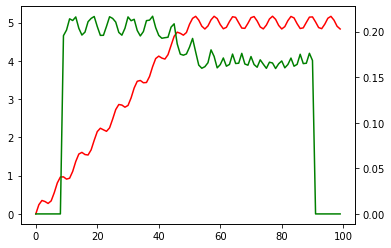

In [11]:
# добавим синусоиду
size = 9
degree = 0.9
sin_noise = np.sin(np.arange(linear_data_with_plato_1.shape[0]))/6
lin_data_pl_with_sin_noise = linear_data_with_plato_1 + sin_noise

fig, ax = plt.subplots()
ax2 = ax.twinx()
box_filtered_data = box_filtering(lin_data_pl_with_sin_noise, degree=degree, size=(size,))
ax.plot(lin_data_pl_with_sin_noise, '-r')
ax2.plot(box_filtered_data, '-g')

stats = separability_stats(box_filtered_data, size)
print(stats)
#k_min = stats[0]
#plt.plot(np.ones(100)*k_min)

(0.17408393208621578, 0.66)


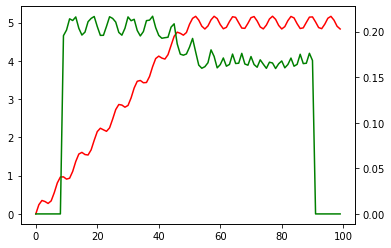

In [56]:
# добавим синусоиду
size = 9
degree = 0.9
sin_noise = np.sin(np.arange(linear_data_with_plato_1.shape[0]))/6
lin_data_pl_with_sin_noise = linear_data_with_plato_1 + sin_noise

fig, ax = plt.subplots()
ax2 = ax.twinx()
box_filtered_data = box_filtering(lin_data_pl_with_sin_noise, degree=degree, size=(size,))
ax.plot(lin_data_pl_with_sin_noise, '-r')
ax2.plot(box_filtered_data, '-g')

stats = separability_stats(box_filtered_data, size)
print(stats)
#k_min = stats[0]
#plt.plot(np.ones(100)*k_min)

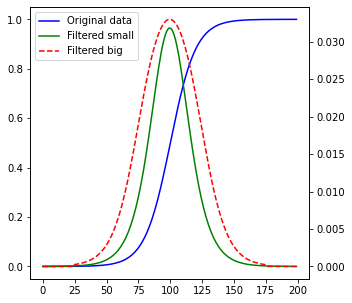

In [71]:
fig, ax = plt.subplots(figsize=(5, 5))
sigmoid_data = 1/(1 + np.exp(np.arange(10, -10, -.1)))

box_filtered_small = box_filtering(sigmoid_data, .9, size=(1,))
box_filtered_big = box_filtering(sigmoid_data, .9, size=(25,))

ln1 = ax.plot(sigmoid_data, '-b', label='Original data')
ax2 = ax.twinx()
ln2 = ax2.plot(box_filtered_small, '-g', label='Filtered small')
ln3 = ax2.plot(box_filtered_big, '--r', label='Filtered big')


ax.legend()
lns = ln1 + ln2 + ln3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

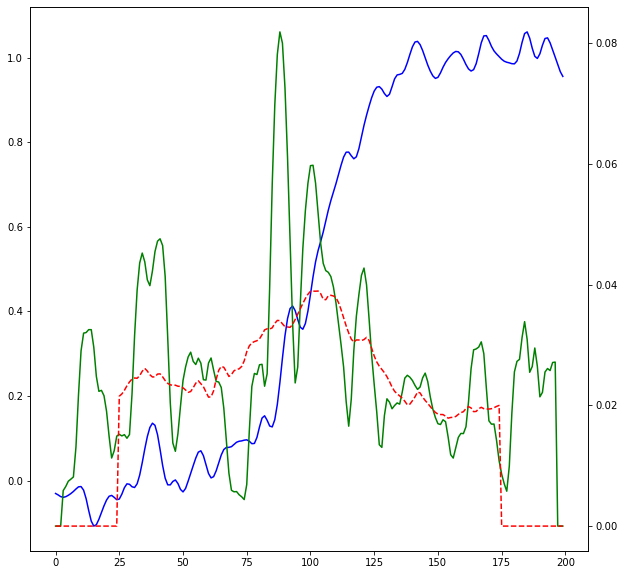

In [95]:
fig, ax = plt.subplots(figsize=(10, 10))
noise = np.random.normal(0, 1, 200)/10
sigmoid_data = gaussian_filter1d(1/(1 + np.exp(np.arange(10, -10, -.1))) + noise, 2)

box_filtered_small = box_filtering(sigmoid_data, 1.9, size=(3,))
box_filtered_big = box_filtering(sigmoid_data, .9, size=(25,))

ln1 = ax.plot(sigmoid_data, '-b', label='Original data')
ax2 = ax.twinx()
ln2 = ax2.plot(box_filtered_small, '-g', label='Filtered small')
ln3 = ax2.plot(box_filtered_big, '--r', label='Filtered big')

plt.show()
# ax.legend()
# lns = ln1 + ln2
# labs = [l.get_label() for l in lns]
# ax.legend(lns, labs, loc=0)

$$f(x) = \frac{1}{1+e^{-x}} + N(\mu, \sigma)$$
$$f'(x) = |ln(1+e^x) + \int_{x_0}^{x_0+\delta x} N(\mu, \sigma) dx|^d$$


In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sigmoid_data = 1/(1 + np.exp(np.arange(10, -10, -.1)))

box_filtered_small = box_filtering(sigmoid_data, 0.8, size=(1,))
box_filtered_bigger = box_filtering(sigmoid_data, 1.5, size=(25,))
print(box_filtered_small.max())
print(box_filtered_bigger.max())

ax.plot(sigmoid_data, label='original', linestyle='solid')
ax.plot(box_filtered_small, label='d=0.5')
ax.plot(box_filtered_bigger, label='d=1.5')
ax.legend()


In [ ]:
# линейная функция с шумом распределенным по нормальному закону
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
data = np.zeros(xs.shape)
noise = np.random.normal(0, .1, data.shape)
data = noise + data 
box_filtered = box_filtering(data, degree=0.9, size=(25,))

ax[0].plot(data, label='x')
ax[0].legend()

ax[1].plot(box_filtered, label='Filtered')
ax[1].legend()


print(f' Максимальное значение фильтра: {box_filtered.max()}')

In [ ]:
# Пойдем механически
noise = np.random.normal(0, 1, xs.shape)
data = noise + xs
results = dict()
for cur_degree in range(1, 30):
    for cur_size in range(1, 25):
        box_filtered = box_filtering(data, degree=cur_degree/10, size=(cur_size,))
        cur_max_value = box_filtered.max()
        results[cur_max_value] = {'degree': cur_degree/10, 'size': cur_size}


In [ ]:
data = np.copy(xs)
data[80:120] = np.exp(-data[80:120]) * 5
data = data + noise

fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
ax[0].plot(data, label='Original', linestyle='dashed')
for i in range(1, 5):
    ax[0].plot(box_filtering(data, degree=i*2/10, size=(1,)), label=f'd={i*2/10}')
    
ax[1].plot(data, label='Original', linestyle='dashed')
for j in range(1, 27, 3):
    ax[1].plot(box_filtering(data, degree=0.8, size=(j,)), label=f's={j}')
    

ax[0].legend()
ax[1].legend()

In [ ]:
small_filtered = box_filtering(data, .8, size=(1,))
big_filtered = box_filtering(data, 1.2, size=(23,))

result_filtered = small_filtered + big_filtered

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(data, label='Original', linestyle='dashed')
#ax.plot(small_filtered, label='Small box filtered', linestyle='dashed')
#ax.plot(big_filtered, label='Big box filtered', linestyle='dashed')
ax.plot(result_filtered, label='Result_filter')

ax.legend()